In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator, Pauli

import qiskit.quantum_info as qi
import numpy as np
import pandas as pd

from qiskit import BasicAer
from qiskit.quantum_info import process_fidelity

from qiskit.extensions import RXGate, XGate, CXGate

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

In [2]:
# Graph
import networkx as nx

def graph_maker(n, G_i):
    nnodes = n
    # create graph objects
    G_comp = nx.complete_graph(nnodes)
    G_star = nx.star_graph(nnodes-1)
    G_bp = nx.complete_bipartite_graph(nnodes//2,nnodes//2)

    G_set = [G_bp, G_star, G_comp]
    G = G_set[G_i]
    # illustrate graph
    nx.draw(G, with_labels=True, node_color = 'green', node_size = 500)
    
    return G

#g_sample = graph_maker(6,0)

#print(g_sample)

In [3]:
# MaxCut Objective
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1

    return obj

In [4]:
# Expectation Value
def compute_expectation(counts, G):
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
    
    #print(f'Expected objective value is : {avg/sum_count}')
    #obj_list.append(avg/sum_count)
    
    return avg/sum_count

In [5]:
# QAOA put together
# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    global vN, iter_num, schmidt
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
    
    #psi_AB = qi.Statevector.from_instruction(qc)
    #psi_AB.draw('latex', prefix='|\\psi_{AB}\\rangle = ')
    rho_AB = qi.DensityMatrix.from_instruction(qc)
    #rho_AB.draw('latex', prefix='\\rho_{AB} = ')
    #print(f'The density matrix associated with this circuit is {rho_AB}')
    rho_A = qi.partial_trace(rho_AB,[i for i in range(0, nqubits//2)])
    vN_A = qi.entropy(rho_A)
    
    vN.append(vN_A)
    schmidt = np.linalg.matrix_rank(rho_A)
    iter_num += 1
    
    #print(f'The bipartite von Neumann entropy is : {vN_A}')
        
    #print(f'This is the {iter_num}th iteration of QAOA')
    #print(vN)

    qc.measure_all()
                    
    #print(qc)

    return qc

In [6]:
# Running the circuit
# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, shots=2048):
        
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=2048).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

For a Complete Bipartite Graph with 4 nodes/qubits and a QAOA circuit with 1 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.2581133248644927.
It ranged from 0.5948824959160879 to 1.4063271952483627,with a mean of 1.2044479067236067and a standard deviation of 0.1784087419784114.
The initial parameters were : [1.0, 1.0].
The optimized parameters are : [1.97196795 1.16377673].
The total number of iterations required : 34.


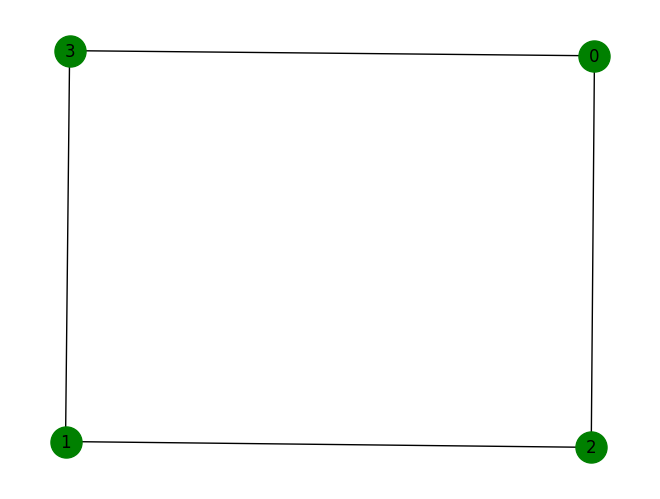

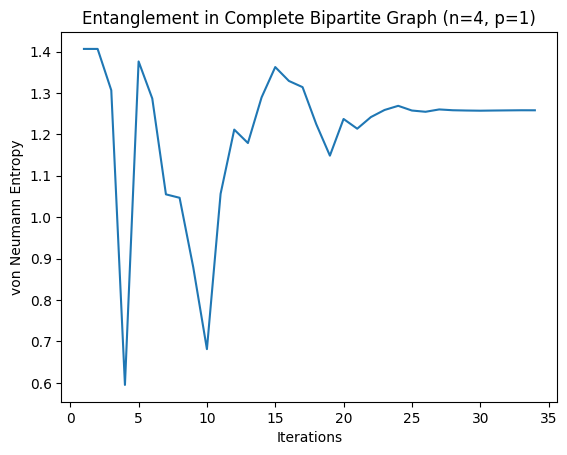

The expectation value of the cut is : 3.046875.
The solutions are : 0011, 1100 with a MaxCut = 4.
--End of 1 layer analysis--
For a Complete Bipartite Graph with 4 nodes/qubits and a QAOA circuit with 2 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.0107202633254544.
It ranged from 0.12243316333072546 to 1.5181196894663964,with a mean of 1.101557843017292and a standard deviation of 0.2277108537668061.
The initial parameters were : [1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [2.11841312 2.04440492 1.12132851 1.00830629].
The total number of iterations required : 41.


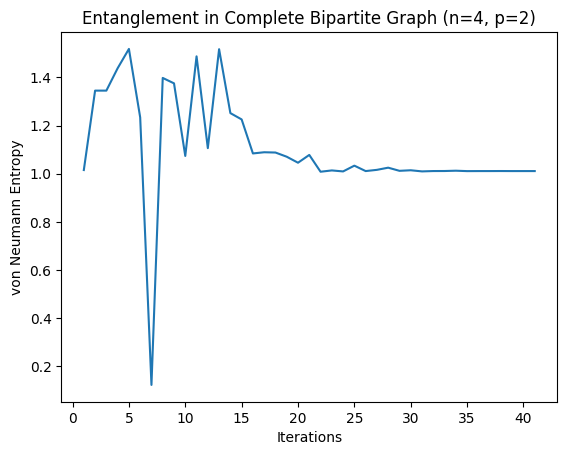

The expectation value of the cut is : 3.994140625.
The solutions are : 0011, 1100 with a MaxCut = 4.
--End of 2 layer analysis--
For a Complete Bipartite Graph with 4 nodes/qubits and a QAOA circuit with 3 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.002153216283447.
It ranged from 0.3570555376337316 to 1.5415338384698052,with a mean of 1.0822092711069289and a standard deviation of 0.19769843410490173.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.18469392 2.02067355 1.96731298 1.73007505 1.14472392 1.0276256 ].
The total number of iterations required : 69.


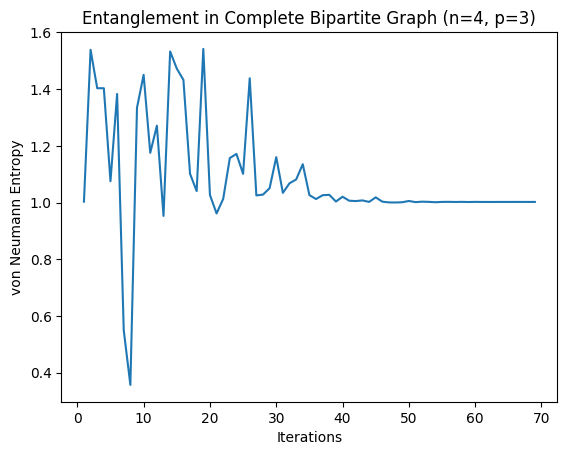

The expectation value of the cut is : 4.0.
The solutions are : 0011, 1100 with a MaxCut = 4.
--End of 3 layer analysis--
For a Complete Bipartite Graph with 4 nodes/qubits and a QAOA circuit with 4 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.023591553138991.
It ranged from 0.3972611469543087 to 1.5512030498869818,with a mean of 1.1029555912363018and a standard deviation of 0.17091701101437207.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [0.93267207 1.19429964 1.30898716 2.06111184 0.74952436 0.84478164
 0.91420068 1.02820788].
The total number of iterations required : 84.


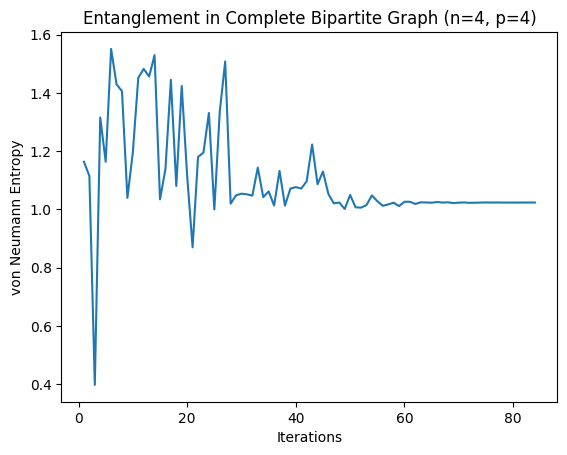

The expectation value of the cut is : 3.99609375.
The solutions are : 0011, 1100 with a MaxCut = 4.
--End of 4 layer analysis--
For a Complete Bipartite Graph with 4 nodes/qubits and a QAOA circuit with 5 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.0247241796500792.
It ranged from 0.5298299550684983 to 1.492068341235111,with a mean of 1.0708651170521142and a standard deviation of 0.1261542074391619.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [2.12326048 1.08733788 1.01451873 2.17040225 1.1235838  0.98074227
 0.97189476 0.9020855  1.08990673 0.94346372].
The total number of iterations required : 109.


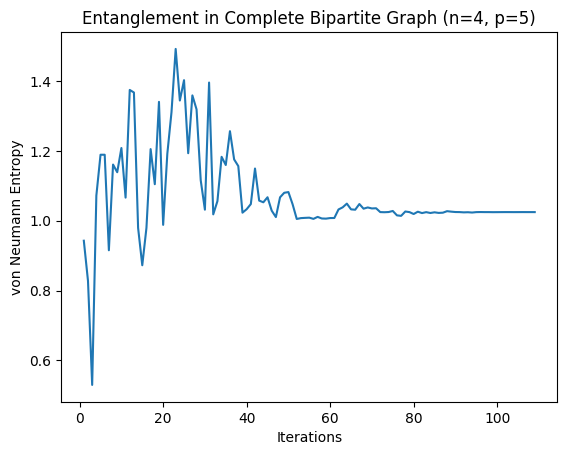

The expectation value of the cut is : 3.99609375.
The solutions are : 0011, 1100 with a MaxCut = 4.
--End of 5 layer analysis--
For a Complete Bipartite Graph with 4 nodes/qubits and a QAOA circuit with 6 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.0072809516856205.
It ranged from 0.24634008193140047 to 1.5680567150187246,with a mean of 1.1018050948954812and a standard deviation of 0.1786412477204994.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.96250287 1.89137754 1.01492544 0.82062258 1.0415699  1.08362236
 0.8760245  1.06742223 0.9837682  1.00594527 0.89480799 1.10140133].
The total number of iterations required : 105.


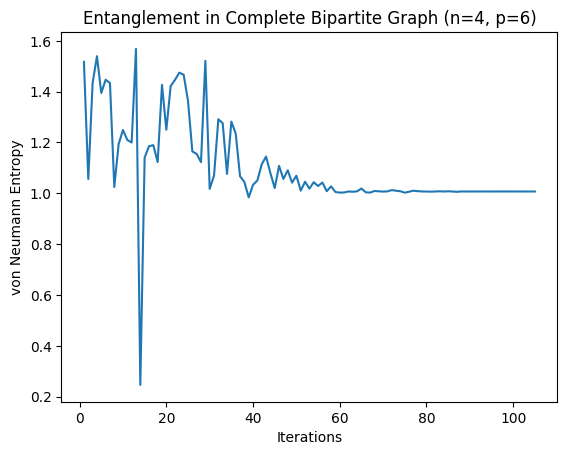

The expectation value of the cut is : 3.998046875.
The solutions are : 0011, 1100 with a MaxCut = 4.
--End of 6 layer analysis--
For a Complete Bipartite Graph with 4 nodes/qubits and a QAOA circuit with 7 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.027547388007988.
It ranged from 0.2184322606430237 to 1.5721395856140172,with a mean of 1.1026419265349803and a standard deviation of 0.181534851554136.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [2.16171579 1.93084066 0.91611903 0.82945658 1.99395738 0.94180213
 0.97837274 0.95301836 0.95669292 1.01402591 0.9280171  0.96817798
 0.9772127  0.93682833].
The total number of iterations required : 113.


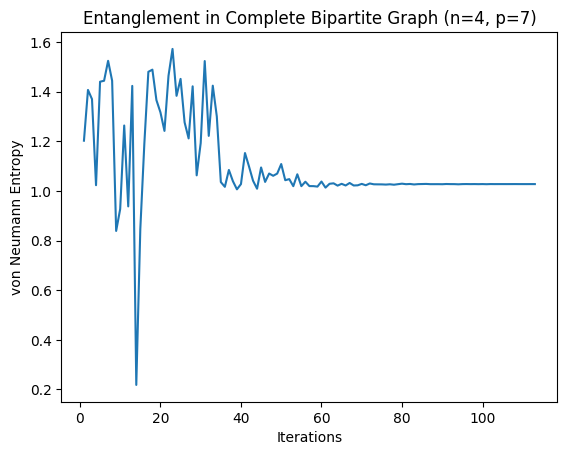

The expectation value of the cut is : 3.99609375.
The solutions are : 0011, 1100 with a MaxCut = 4.
--End of 7 layer analysis--
For a Complete Bipartite Graph with 4 nodes/qubits and a QAOA circuit with 8 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.0002202000411358.
It ranged from 0.4482969928935446 to 1.5167810783433064,with a mean of 1.0598431999043325and a standard deviation of 0.15535157471717517.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [0.99507308 1.6743001  0.9379226  1.01007157 1.01938732 1.02996145
 1.26737769 0.97211943 1.00009311 0.98401781 0.98915784 0.9490906
 0.87771188 0.99156498 0.99866022 0.9862206 ].
The total number of iterations required : 138.


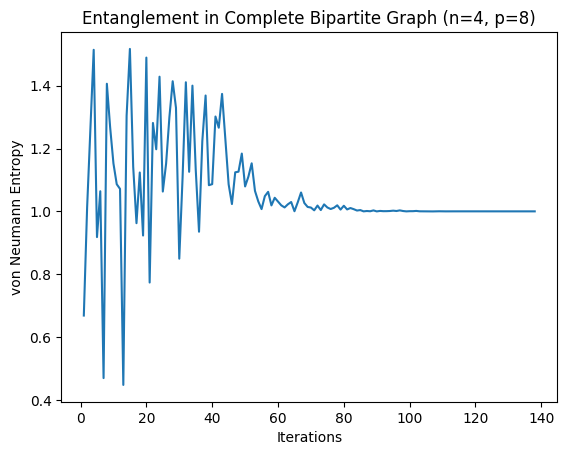

The expectation value of the cut is : 4.0.
The solutions are : 0011, 1100 with a MaxCut = 4.
--End of 8 layer analysis--


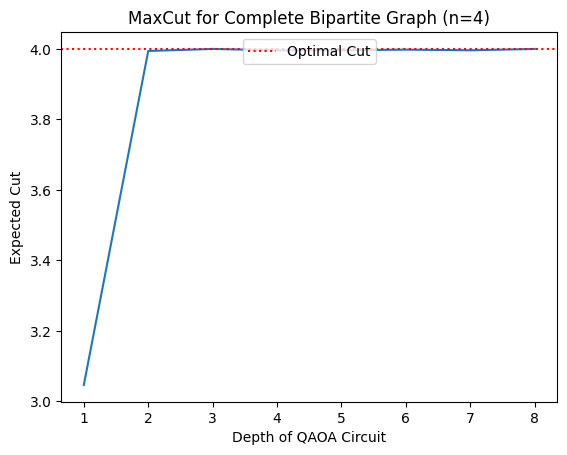

--End of 4 qubit analysis--
For a Complete Bipartite Graph with 6 nodes/qubits and a QAOA circuit with 1 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 1.478914411678419.
It ranged from 0.43539956467088015 to 1.6476286017062802,with a mean of 1.4266278489535673and a standard deviation of 0.23989285144783007.
The initial parameters were : [1.0, 1.0].
The optimized parameters are : [1.20097328 1.24880793].
The total number of iterations required : 29.


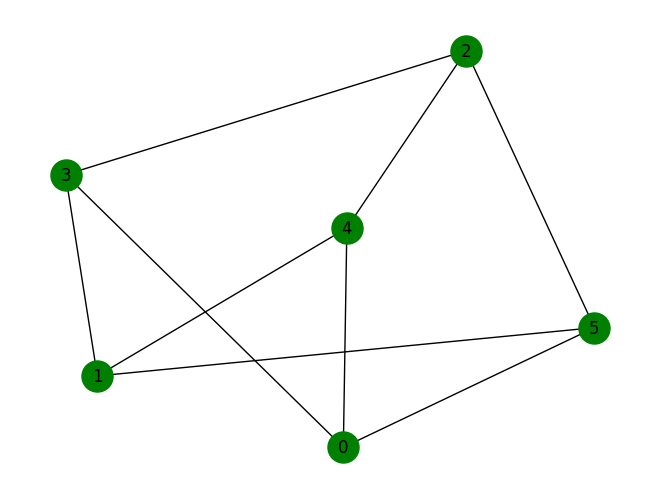

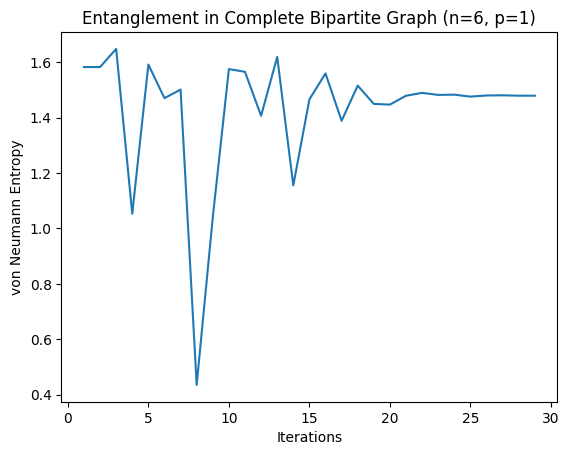

The expectation value of the cut is : 6.171875.
The solutions are : 000111, 111000 with a MaxCut = 9.
--End of 1 layer analysis--
For a Complete Bipartite Graph with 6 nodes/qubits and a QAOA circuit with 2 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 1.5287649451082854.
It ranged from 0.2850811588553434 to 1.9375662584405628,with a mean of 1.4419056643623294and a standard deviation of 0.3070699249325369.
The initial parameters were : [1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.1736221  2.2446484  1.97508542 1.34960817].
The total number of iterations required : 55.


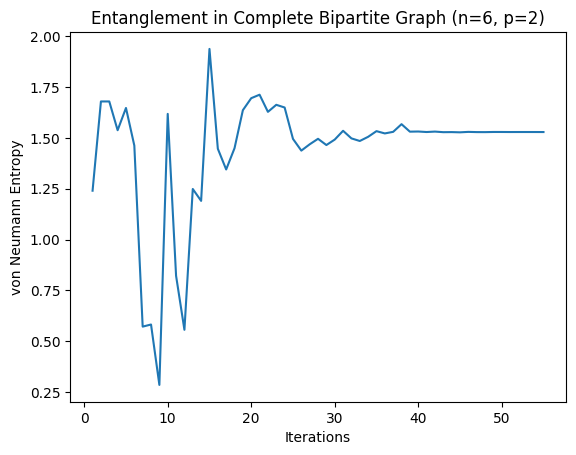

The expectation value of the cut is : 7.7099609375.
The solutions are : 000111, 111000 with a MaxCut = 9.
--End of 2 layer analysis--
For a Complete Bipartite Graph with 6 nodes/qubits and a QAOA circuit with 3 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 1.1776881186825052.
It ranged from 0.9505085211800717 to 1.7604478075787269,with a mean of 1.245826260747162and a standard deviation of 0.16179619840165732.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [2.05727733 1.13652085 2.35091046 0.98956085 1.14481554 0.94702141].
The total number of iterations required : 76.


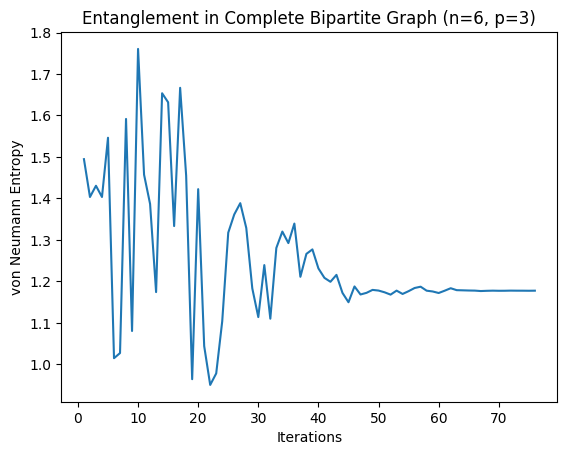

The expectation value of the cut is : 8.5703125.
The solutions are : 000111, 111000 with a MaxCut = 9.
--End of 3 layer analysis--
For a Complete Bipartite Graph with 6 nodes/qubits and a QAOA circuit with 4 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 1.1713124034182658.
It ranged from 0.8163781331845651 to 1.8095304817491182,with a mean of 1.2571265537651126and a standard deviation of 0.16867946682615972.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.983794   1.05306002 0.91240361 1.04635958 0.96884776 0.96563684
 0.96035719 0.90180881].
The total number of iterations required : 97.


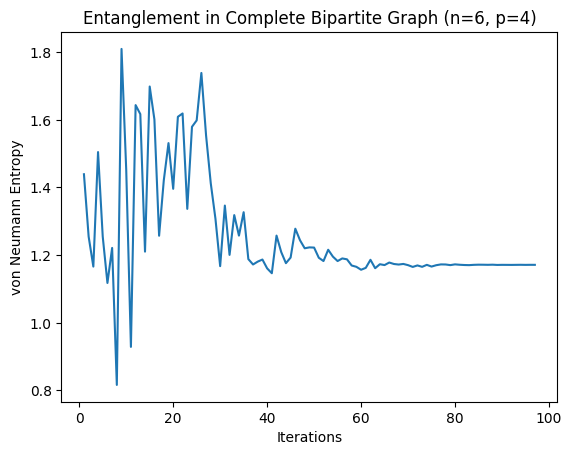

The expectation value of the cut is : 8.7919921875.
The solutions are : 000111, 111000 with a MaxCut = 9.
--End of 4 layer analysis--
For a Complete Bipartite Graph with 6 nodes/qubits and a QAOA circuit with 5 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 1.3639813630468094.
It ranged from 0.9911491511485381 to 1.822162439695938,with a mean of 1.4504521652642197and a standard deviation of 0.1309702218011443.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.05506345 1.06868276 1.08089065 0.91772789 0.90004497 0.90226138
 1.97019966 1.07792022 0.88730801 1.02266409].
The total number of iterations required : 155.


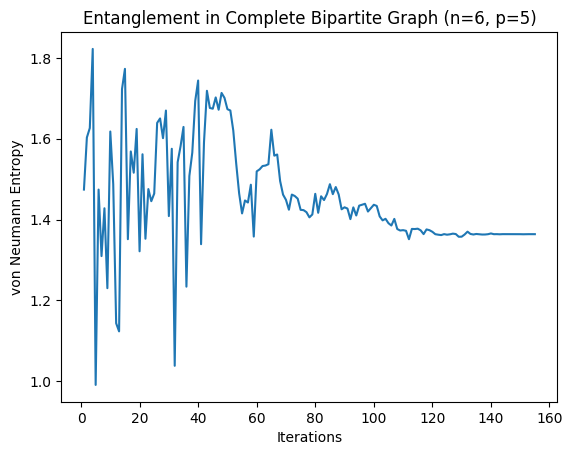

The expectation value of the cut is : 8.6201171875.
The solutions are : 000111, 111000 with a MaxCut = 9.
--End of 5 layer analysis--
For a Complete Bipartite Graph with 6 nodes/qubits and a QAOA circuit with 6 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 1.0804344524743645.
It ranged from 0.9084407241473091 to 1.8366650836411227,with a mean of 1.2117715980565615and a standard deviation of 0.19130403795787812.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [0.96830953 1.95311911 0.99110576 0.99793694 0.98495708 2.2273465
 0.99465812 1.98254747 1.11463084 1.02933798 0.99214625 1.0020823 ].
The total number of iterations required : 143.


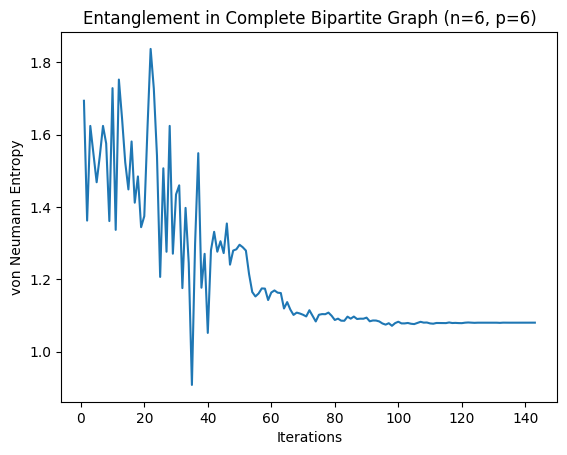

The expectation value of the cut is : 8.8681640625.
The solutions are : 000111, 111000 with a MaxCut = 9.
--End of 6 layer analysis--
For a Complete Bipartite Graph with 6 nodes/qubits and a QAOA circuit with 7 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 1.0388230969137013.
It ranged from 0.39427018880698533 to 1.9097129356872347,with a mean of 1.1947013963993913and a standard deviation of 0.21082500724370973.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [2.05242388 1.99300537 1.06341897 1.10362786 0.89227212 1.09195501
 1.00638973 1.12328271 1.00291624 1.00546869 1.01741314 0.94690306
 1.95493224 1.02492924].
The total number of iterations required : 213.


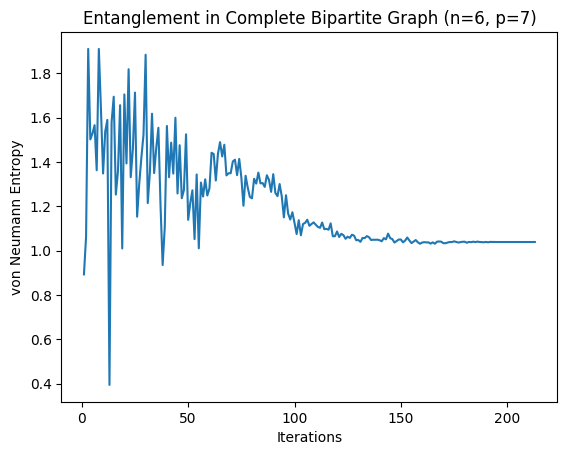

The expectation value of the cut is : 8.986328125.
The solutions are : 000111, 111000 with a MaxCut = 9.
--End of 7 layer analysis--
For a Complete Bipartite Graph with 6 nodes/qubits and a QAOA circuit with 8 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 1.0151248925247875.
It ranged from 0.9000995525538344 to 1.9693942738944155,with a mean of 1.18261884771113and a standard deviation of 0.23788718373972362.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [2.01741458 1.13137588 0.82511268 0.94703645 1.14184734 0.94380621
 0.99073136 0.96993091 1.06149547 2.01050034 1.02784484 1.86081573
 1.11696191 0.88085472 1.05355731 1.01078428].
The total number of iterations required : 206.


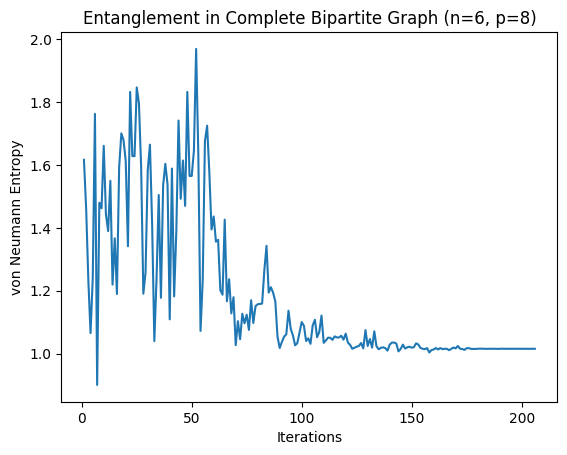

The expectation value of the cut is : 8.978515625.
The solutions are : 000111, 111000 with a MaxCut = 9.
--End of 8 layer analysis--


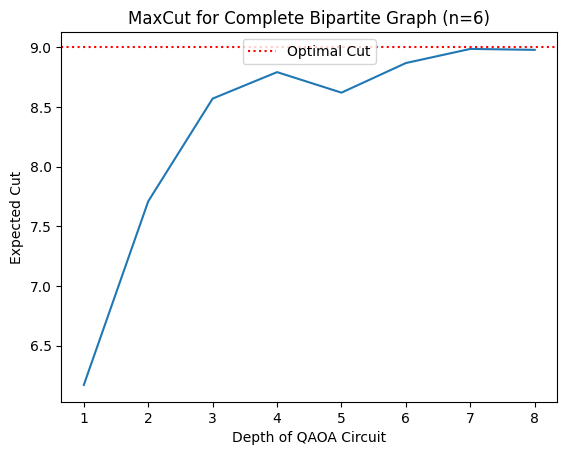

--End of 6 qubit analysis--
For a Complete Bipartite Graph with 8 nodes/qubits and a QAOA circuit with 1 layers:
The Schmidt number is : 5.
The final von Neumann entropy is : 1.5660140070000244.
It ranged from 0.4642522961144629 to 1.823829890999936,with a mean of 1.5460342079828262and a standard deviation of 0.2942817814938449.
The initial parameters were : [1.0, 1.0].
The optimized parameters are : [1.94382857 1.31477165].
The total number of iterations required : 34.


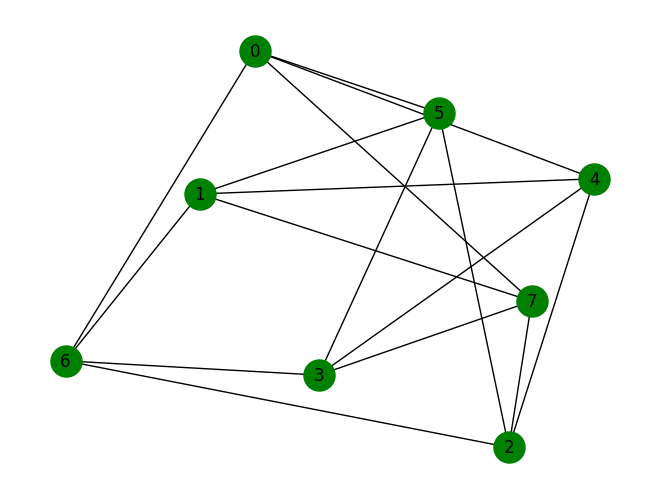

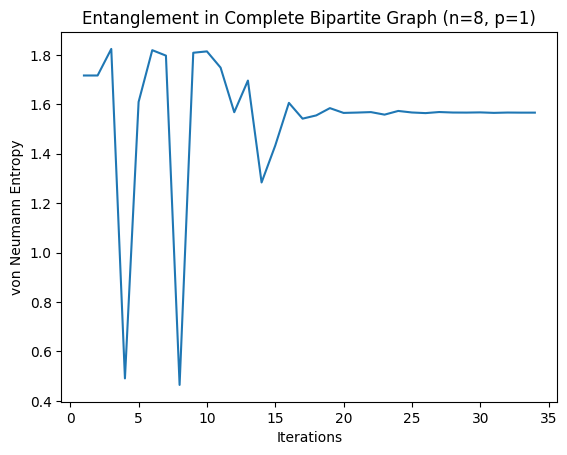

The expectation value of the cut is : 10.65625.
The solutions are : 00001111, 11110000 with a MaxCut = 16.
--End of 1 layer analysis--
For a Complete Bipartite Graph with 8 nodes/qubits and a QAOA circuit with 2 layers:
The Schmidt number is : 5.
The final von Neumann entropy is : 1.8942077949977842.
It ranged from 1.6145163361854533 to 2.131583582970728,with a mean of 1.8815248308713346and a standard deviation of 0.11019202905397724.
The initial parameters were : [1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.92665666 2.13437706 1.19057605 0.99370167].
The total number of iterations required : 54.


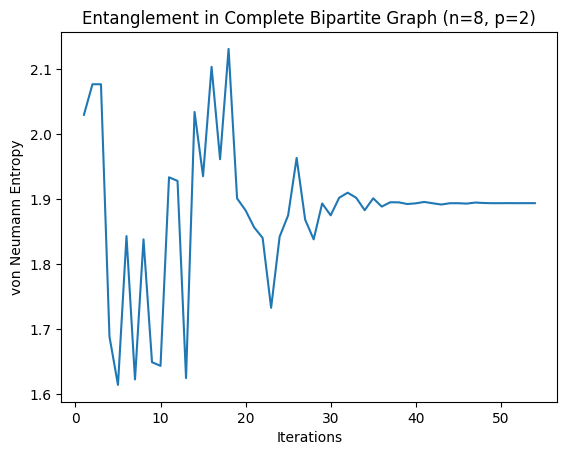

The expectation value of the cut is : 13.470703125.
The solutions are : 00001111, 11110000 with a MaxCut = 16.
--End of 2 layer analysis--
For a Complete Bipartite Graph with 8 nodes/qubits and a QAOA circuit with 3 layers:
The Schmidt number is : 5.
The final von Neumann entropy is : 1.6427429871311268.
It ranged from 1.4109540078634848 to 2.037548601956142,with a mean of 1.661664259600844and a standard deviation of 0.10967589361576151.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.92000444 2.13112113 1.82229239 1.15787912 0.9572503  0.99095101].
The total number of iterations required : 80.


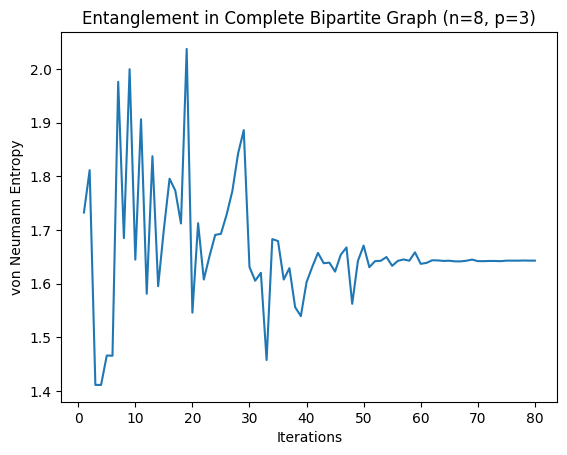

The expectation value of the cut is : 14.03515625.
The solutions are : 00001111, 11110000 with a MaxCut = 16.
--End of 3 layer analysis--
For a Complete Bipartite Graph with 8 nodes/qubits and a QAOA circuit with 4 layers:
The Schmidt number is : 5.
The final von Neumann entropy is : 1.6558755550282134.
It ranged from 0.9714582143094859 to 2.0025073967156324,with a mean of 1.7110828306548813and a standard deviation of 0.1542543221107529.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [0.98737722 1.04308624 0.92813949 1.18085636 0.73167728 0.71318581
 1.05950561 1.01199657].
The total number of iterations required : 104.


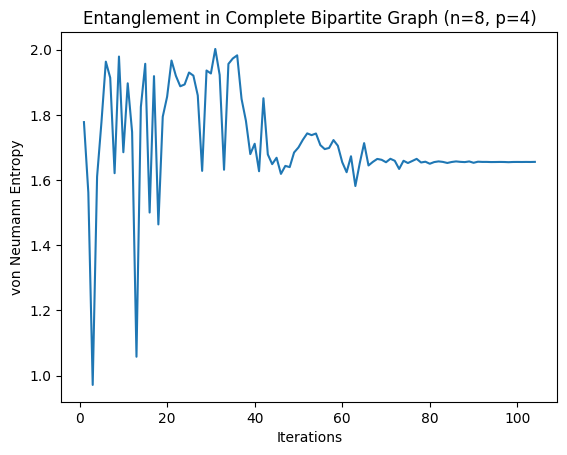

The expectation value of the cut is : 13.330078125.
The solutions are : 00001111, 11110000 with a MaxCut = 16.
--End of 4 layer analysis--
For a Complete Bipartite Graph with 8 nodes/qubits and a QAOA circuit with 5 layers:
The Schmidt number is : 5.
The final von Neumann entropy is : 1.9480353685395466.
It ranged from 1.0520471334611665 to 2.0687463697168673,with a mean of 1.8799571838350475and a standard deviation of 0.14938786988153302.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.05751251 1.97796452 1.92589484 0.98568615 0.99141582 1.22018861
 0.9597259  1.03137627 1.10669862 0.97116112].
The total number of iterations required : 110.


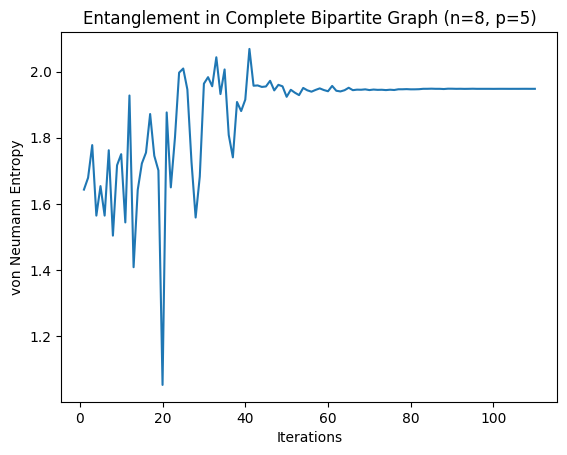

The expectation value of the cut is : 13.12890625.
The solutions are : 00001111, 11110000 with a MaxCut = 16.
--End of 5 layer analysis--
For a Complete Bipartite Graph with 8 nodes/qubits and a QAOA circuit with 6 layers:
The Schmidt number is : 5.
The final von Neumann entropy is : 1.2344488736764643.
It ranged from 1.1378435323985905 to 2.2016843976699105,with a mean of 1.4206644510928643and a standard deviation of 0.2641768881949358.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [0.88085695 0.57628477 2.12345168 1.00831597 2.34076999 0.69027598
 0.96484587 0.45336589 0.65521917 0.84354014 0.69849809 0.62088897].
The total number of iterations required : 140.


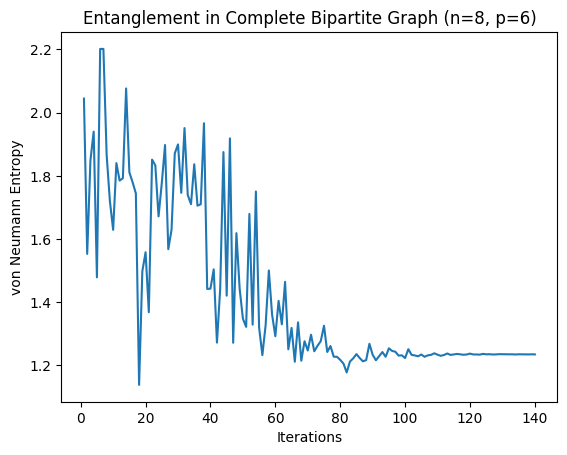

The expectation value of the cut is : 15.1171875.
The solutions are : 00001111, 11110000 with a MaxCut = 16.
--End of 6 layer analysis--
For a Complete Bipartite Graph with 8 nodes/qubits and a QAOA circuit with 7 layers:
The Schmidt number is : 5.
The final von Neumann entropy is : 1.1424594168220294.
It ranged from 1.131298484885269 to 2.0360407060675216,with a mean of 1.335821519401796and a standard deviation of 0.24917501864991046.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.97838301 2.02488825 1.05868092 0.89686306 1.98383973 0.97445586
 1.05187863 0.92652522 0.9960043  0.90769347 0.95417276 0.94935462
 0.94595718 1.11293093].
The total number of iterations required : 193.


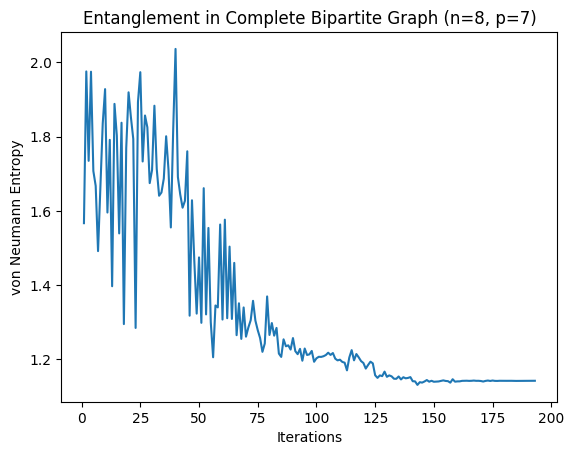

The expectation value of the cut is : 15.765625.
The solutions are : 00001111, 11110000 with a MaxCut = 16.
--End of 7 layer analysis--
For a Complete Bipartite Graph with 8 nodes/qubits and a QAOA circuit with 8 layers:
The Schmidt number is : 5.
The final von Neumann entropy is : 1.3308769403308884.
It ranged from 1.1850972336334735 to 2.1660433101743783,with a mean of 1.5046028843847867and a standard deviation of 0.22139335513167166.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [0.97293423 1.96076749 1.18627858 1.01527849 0.9770523  0.94193908
 1.03838583 0.85244666 1.00365134 0.90362546 0.99635625 2.06823913
 1.0314974  0.96756223 0.90502489 0.99684063].
The total number of iterations required : 209.


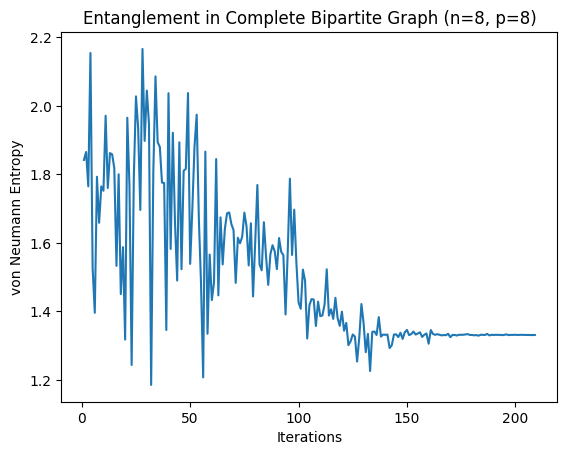

The expectation value of the cut is : 15.28515625.
The solutions are : 00001111, 11110000 with a MaxCut = 16.
--End of 8 layer analysis--


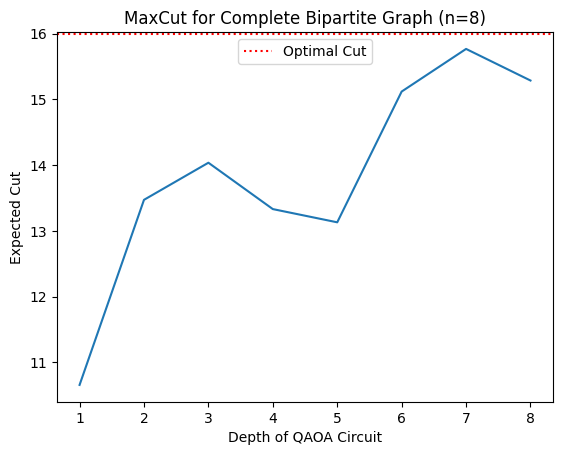

--End of 8 qubit analysis--
--End of Complete Bipartite Graph analysis--
For a Star Graph with 4 nodes/qubits and a QAOA circuit with 1 layers:
The Schmidt number is : 2.
The final von Neumann entropy is : 0.9752988913512721.
It ranged from 0.7171904576550857 to 0.9999981656314866,with a mean of 0.9657246083581896and a standard deviation of 0.05430959340915354.
The initial parameters were : [1.0, 1.0].
The optimized parameters are : [1.16152315 1.00744079].
The total number of iterations required : 31.


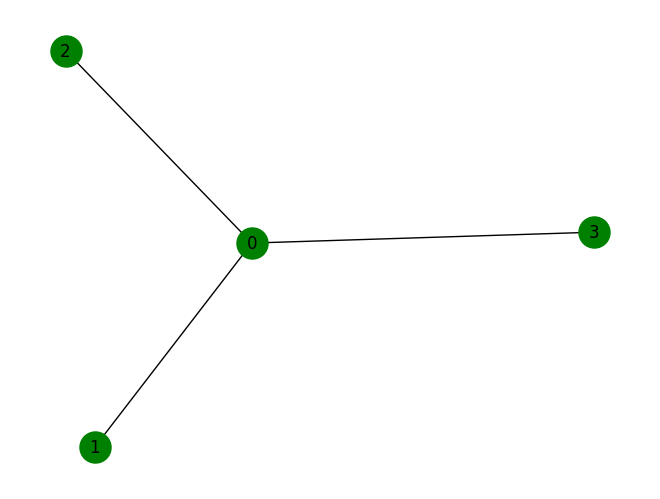

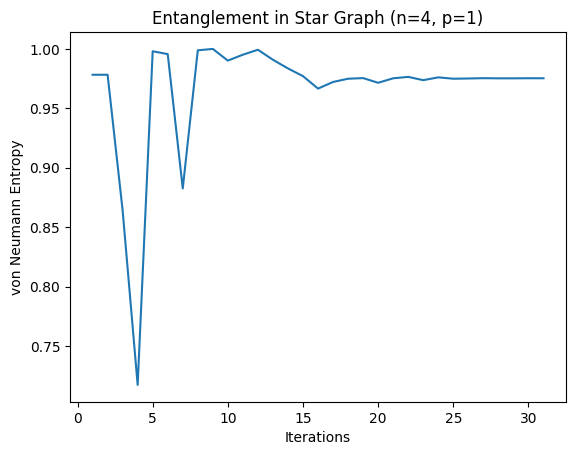

The expectation value of the cut is : 2.3203125.
The solutions are : 0001, 1110 with a MaxCut = 3.
--End of 1 layer analysis--
For a Star Graph with 4 nodes/qubits and a QAOA circuit with 2 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.1756230548282443.
It ranged from 0.954503719339319 to 1.2956732129028747,with a mean of 1.1835092597727928and a standard deviation of 0.05019365487581034.
The initial parameters were : [1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.1443634  1.85959307 1.1195939  0.97164276].
The total number of iterations required : 53.


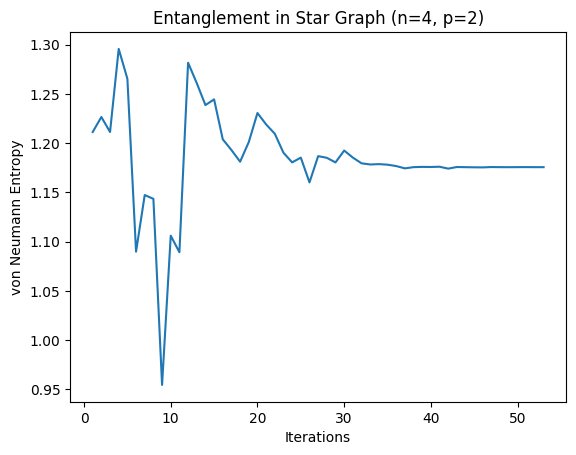

The expectation value of the cut is : 2.794921875.
The solutions are : 0001, 1110 with a MaxCut = 3.
--End of 2 layer analysis--
For a Star Graph with 4 nodes/qubits and a QAOA circuit with 3 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.012535705459651.
It ranged from 0.9180964816460198 to 1.2843003030152362,with a mean of 1.058306679777226and a standard deviation of 0.08072033445069712.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [2.0877845  1.30378263 1.10609476 2.20836389 0.85467627 1.2398772 ].
The total number of iterations required : 68.


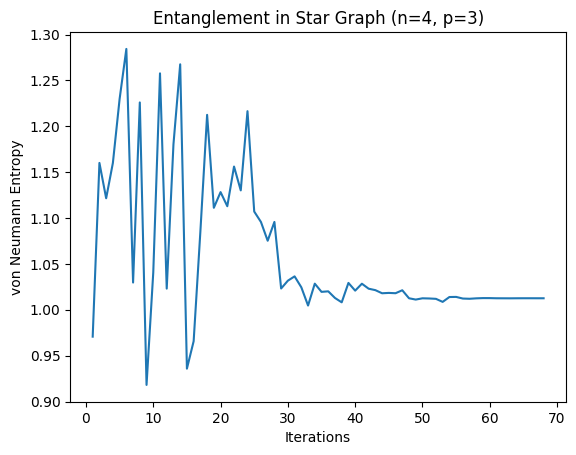

The expectation value of the cut is : 2.9931640625.
The solutions are : 0001, 1110 with a MaxCut = 3.
--End of 3 layer analysis--
For a Star Graph with 4 nodes/qubits and a QAOA circuit with 4 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.0013977250890136.
It ranged from 0.6705422306234068 to 1.4859660166937563,with a mean of 1.072233399065752and a standard deviation of 0.12229087901918682.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [0.74765295 0.60994631 0.2261539  2.20526078 0.72174829 2.30151358
 0.74530298 0.87886069].
The total number of iterations required : 90.


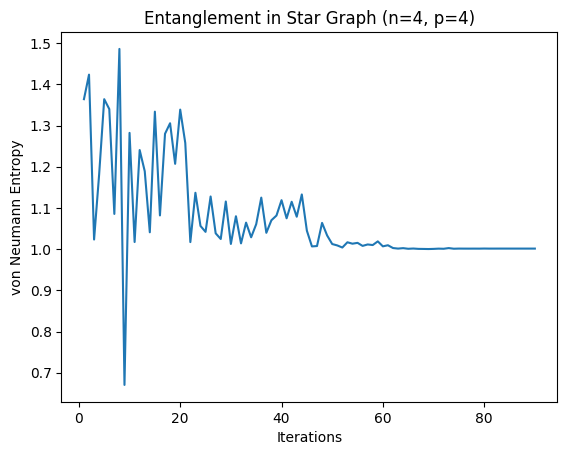

The expectation value of the cut is : 2.998046875.
The solutions are : 0001, 1110 with a MaxCut = 3.
--End of 4 layer analysis--
For a Star Graph with 4 nodes/qubits and a QAOA circuit with 5 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.0132497094979829.
It ranged from 0.8022177620497424 to 1.5422399565443534,with a mean of 1.0750321550233555and a standard deviation of 0.10401470474024882.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.89545603 1.06962346 0.96446962 1.19403685 1.0223475  1.09278082
 1.01674731 0.98684316 0.97084642 1.04896361].
The total number of iterations required : 133.


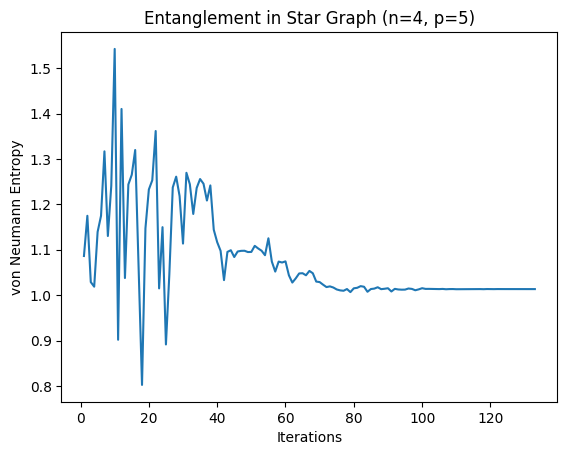

The expectation value of the cut is : 2.9892578125.
The solutions are : 0001, 1110 with a MaxCut = 3.
--End of 5 layer analysis--
For a Star Graph with 4 nodes/qubits and a QAOA circuit with 6 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.0051420520314465.
It ranged from 0.9152891580692504 to 1.5158785364867178,with a mean of 1.0601049411997145and a standard deviation of 0.10418777672041354.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.98337916 0.97511556 0.93305496 0.98472499 0.95216868 1.1504746
 0.89166539 1.04278889 0.87396981 0.9662535  0.90396637 1.03612512].
The total number of iterations required : 115.


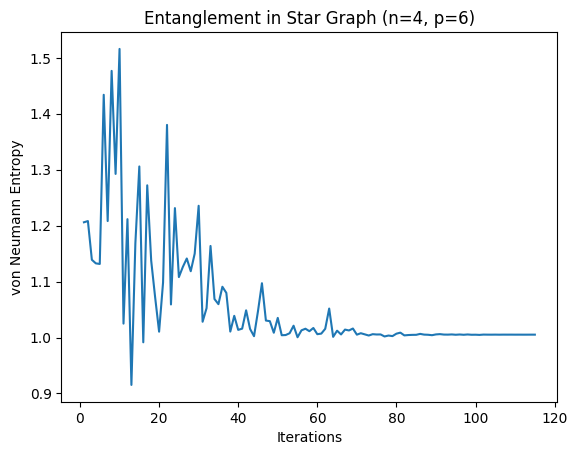

The expectation value of the cut is : 2.998046875.
The solutions are : 0001, 1110 with a MaxCut = 3.
--End of 6 layer analysis--
For a Star Graph with 4 nodes/qubits and a QAOA circuit with 7 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.0056388547112034.
It ranged from 0.9740248434675127 to 1.5471963031214753,with a mean of 1.0897709765500365and a standard deviation of 0.13173637112149633.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.02818053 1.03223803 0.98188516 0.76152866 1.14512428 1.06904153
 2.06200309 1.08255159 0.95765699 2.306793   1.00642396 1.02727211
 1.02218337 0.97122026].
The total number of iterations required : 141.


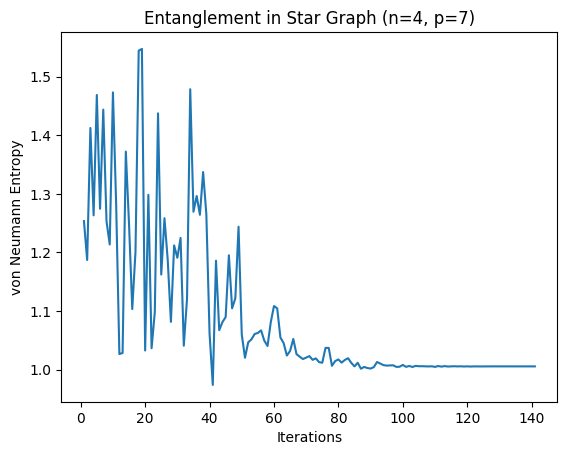

The expectation value of the cut is : 2.998046875.
The solutions are : 0001, 1110 with a MaxCut = 3.
--End of 7 layer analysis--
For a Star Graph with 4 nodes/qubits and a QAOA circuit with 8 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.0104159143111098.
It ranged from 0.6534308116956801 to 1.560139660726557,with a mean of 1.0765862077221784and a standard deviation of 0.129379046210848.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.06006599 2.15152969 0.85609033 0.81233908 0.86617677 0.97347485
 0.74293815 0.99234572 0.92377993 1.01736717 0.86841588 0.84141922
 0.75696548 0.91339905 0.7887587  0.95999452].
The total number of iterations required : 162.


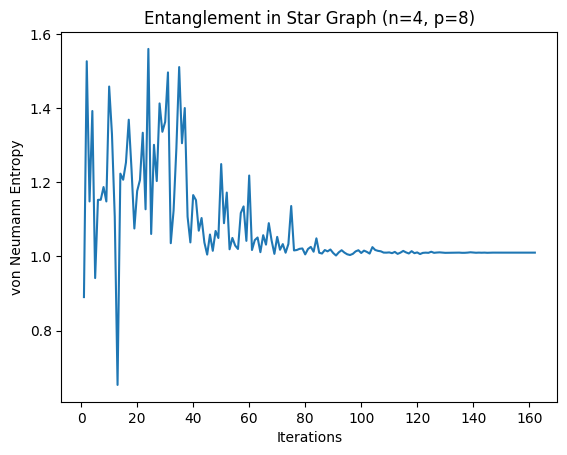

The expectation value of the cut is : 2.9970703125.
The solutions are : 0001, 1110 with a MaxCut = 3.
--End of 8 layer analysis--


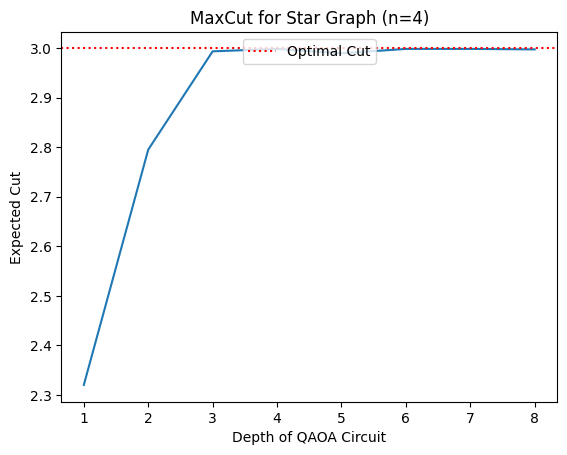

--End of 4 qubit analysis--
For a Star Graph with 6 nodes/qubits and a QAOA circuit with 1 layers:
The Schmidt number is : 2.
The final von Neumann entropy is : 0.9996957047981179.
It ranged from 0.8397579383651992 to 0.9999239850770151,with a mean of 0.9909403066817355and a standard deviation of 0.03133619479390746.
The initial parameters were : [1.0, 1.0].
The optimized parameters are : [1.23420409 0.92411395].
The total number of iterations required : 29.


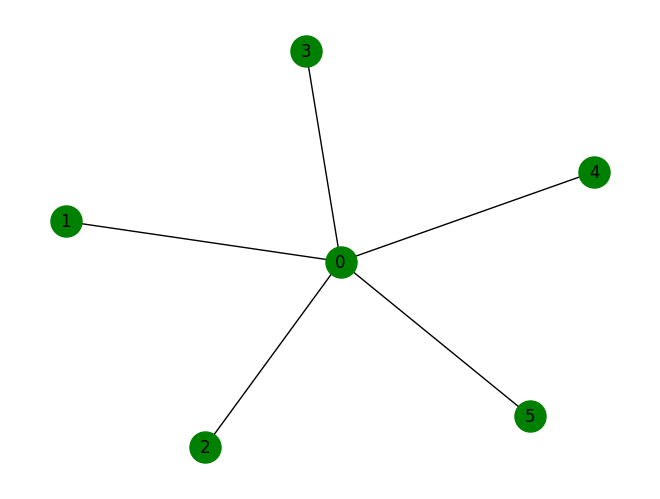

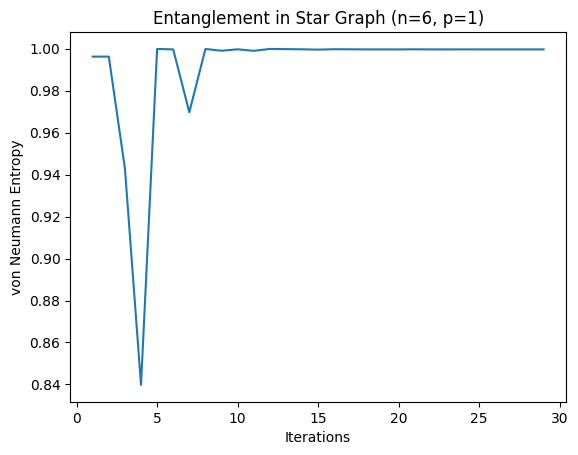

The expectation value of the cut is : 3.7333984375.
The solutions are : 000001, 111110 with a MaxCut = 5.
--End of 1 layer analysis--
For a Star Graph with 6 nodes/qubits and a QAOA circuit with 2 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 1.2356965814818004.
It ranged from 0.3591390058331768 to 1.5661748194841985,with a mean of 1.2381913165089218and a standard deviation of 0.19552733534878608.
The initial parameters were : [1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [0.97465476 1.938912   0.70217114 1.90698381].
The total number of iterations required : 45.


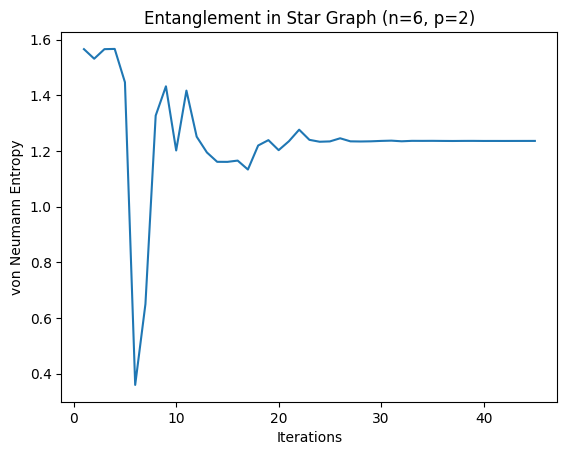

The expectation value of the cut is : 4.470703125.
The solutions are : 000001, 111110 with a MaxCut = 5.
--End of 2 layer analysis--
For a Star Graph with 6 nodes/qubits and a QAOA circuit with 3 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 1.2423108464937183.
It ranged from 0.6734346930274463 to 1.779666320459843,with a mean of 1.214979550028884and a standard deviation of 0.20902204367913457.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.58236194 0.42328354 1.2653288  1.06311837 1.7747578  1.02570539].
The total number of iterations required : 70.


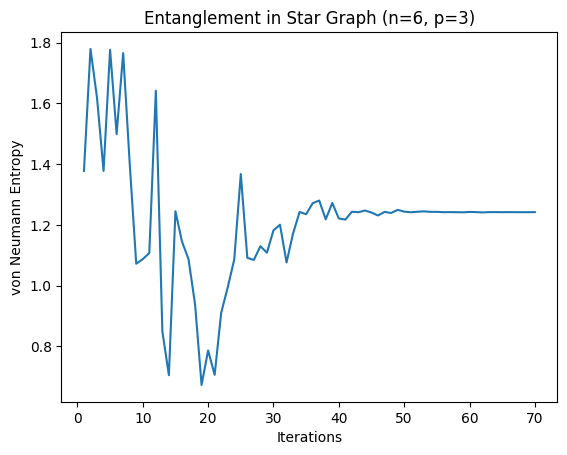

The expectation value of the cut is : 4.298828125.
The solutions are : 000001, 111110 with a MaxCut = 5.
--End of 3 layer analysis--
For a Star Graph with 6 nodes/qubits and a QAOA circuit with 4 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 1.486512230550838.
It ranged from 1.0819992222551071 to 1.8473332809470258,with a mean of 1.5115271886066752and a standard deviation of 0.08688244628698176.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.12336292 1.00189081 2.01017684 0.99061887 0.95973991 0.96759068
 1.00335163 0.98599532].
The total number of iterations required : 89.


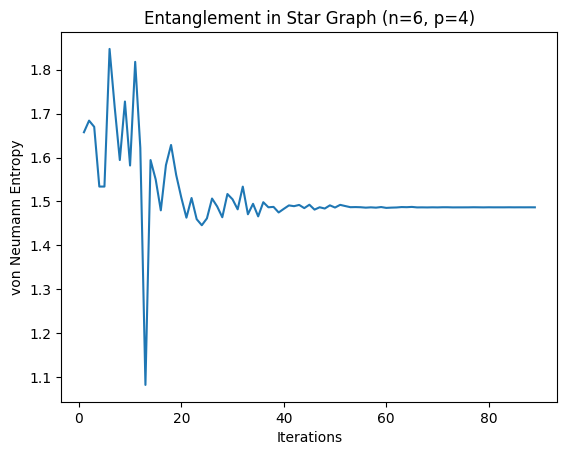

The expectation value of the cut is : 4.3974609375.
The solutions are : 000001, 111110 with a MaxCut = 5.
--End of 4 layer analysis--
For a Star Graph with 6 nodes/qubits and a QAOA circuit with 5 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 1.164722165742814.
It ranged from 1.0741124154493291 to 1.9452342764322628,with a mean of 1.3153821791884632and a standard deviation of 0.19746153003008513.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [0.92524807 0.89553831 0.959832   0.82520907 1.1883986  1.06418507
 0.98451375 0.91681649 0.82051466 0.94502928].
The total number of iterations required : 143.


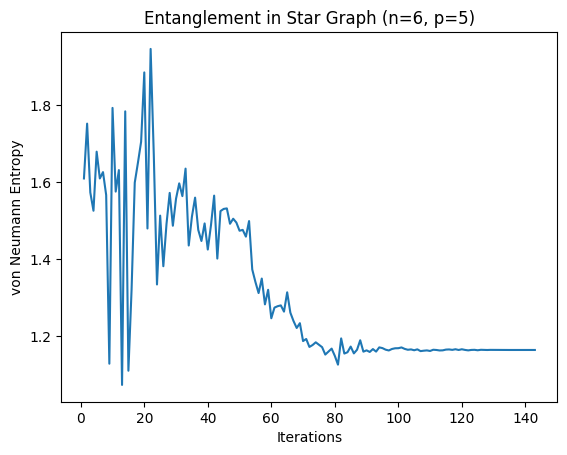

The expectation value of the cut is : 4.7919921875.
The solutions are : 000001, 111110 with a MaxCut = 5.
--End of 5 layer analysis--
For a Star Graph with 6 nodes/qubits and a QAOA circuit with 6 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 1.2118558967152786.
It ranged from 1.1708737898623296 to 1.9402814224771736,with a mean of 1.4126650152777938and a standard deviation of 0.21406529675863184.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [0.68028569 1.99950064 1.07150581 0.94006948 1.72217807 0.95929533
 0.94391289 1.09393141 0.90940948 1.16396223 1.20962498 0.90599214].
The total number of iterations required : 174.


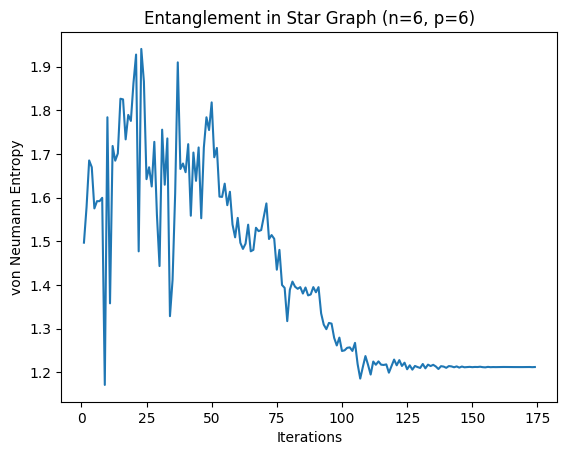

The expectation value of the cut is : 4.740234375.
The solutions are : 000001, 111110 with a MaxCut = 5.
--End of 6 layer analysis--
For a Star Graph with 6 nodes/qubits and a QAOA circuit with 7 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 1.0925635695108509.
It ranged from 1.080828900878303 to 1.8502309710269111,with a mean of 1.2494763687877213and a standard deviation of 0.22444214430305845.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [0.68079666 0.90960014 0.88701526 0.85343733 0.92824206 0.85528496
 0.79238075 0.80102798 0.78952932 0.89172111 0.86666778 0.87138682
 0.97422838 0.81252619].
The total number of iterations required : 144.


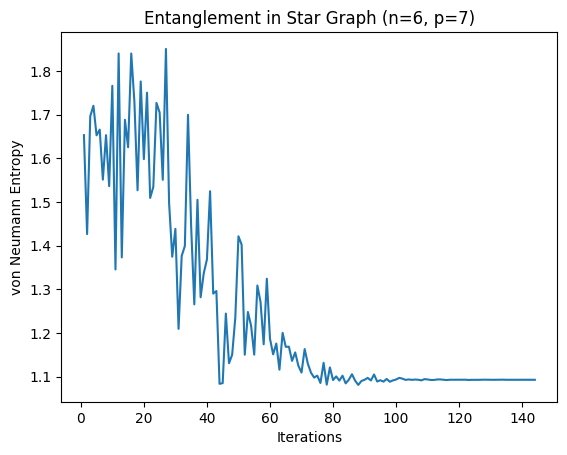

The expectation value of the cut is : 4.880859375.
The solutions are : 000001, 111110 with a MaxCut = 5.
--End of 7 layer analysis--
For a Star Graph with 6 nodes/qubits and a QAOA circuit with 8 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 1.122154115955629.
It ranged from 1.107475889927114 to 1.8979877682580177,with a mean of 1.2812966359210123and a standard deviation of 0.21874718572603444.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.08456857 1.06325212 1.97462147 0.93605451 1.08614913 1.039857
 0.83543453 1.15753557 0.92786653 0.905936   1.0976218  1.14646353
 0.95781678 0.92508839 0.92718221 0.98106669].
The total number of iterations required : 192.


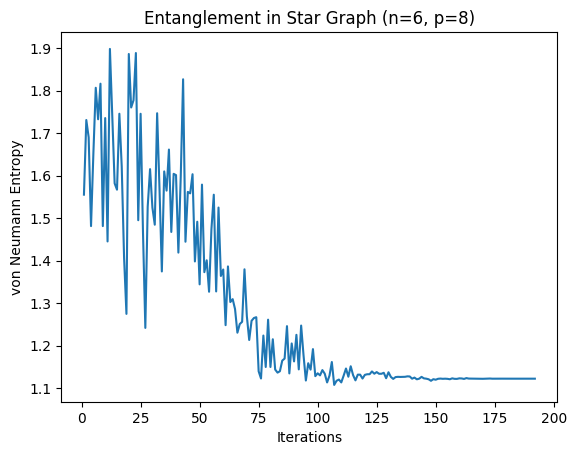

The expectation value of the cut is : 4.828125.
The solutions are : 000001, 111110 with a MaxCut = 5.
--End of 8 layer analysis--


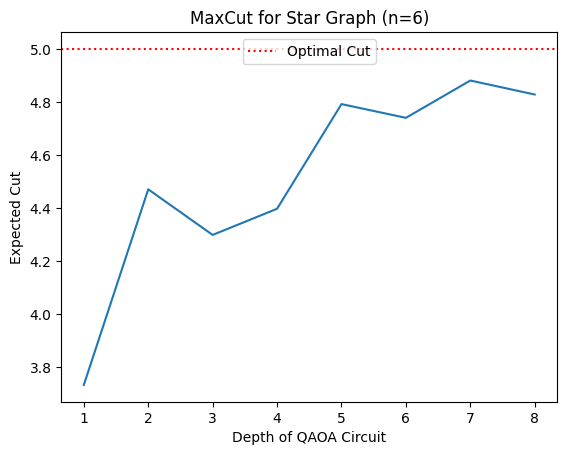

--End of 6 qubit analysis--
For a Star Graph with 8 nodes/qubits and a QAOA circuit with 1 layers:
The Schmidt number is : 2.
The final von Neumann entropy is : 1.0000000000000018.
It ranged from 0.9295390432740531 to 1.0000000000000233,with a mean of 0.9970023202246592and a standard deviation of 0.012293755549219946.
The initial parameters were : [1.0, 1.0].
The optimized parameters are : [1.17616864 0.77941103].
The total number of iterations required : 37.


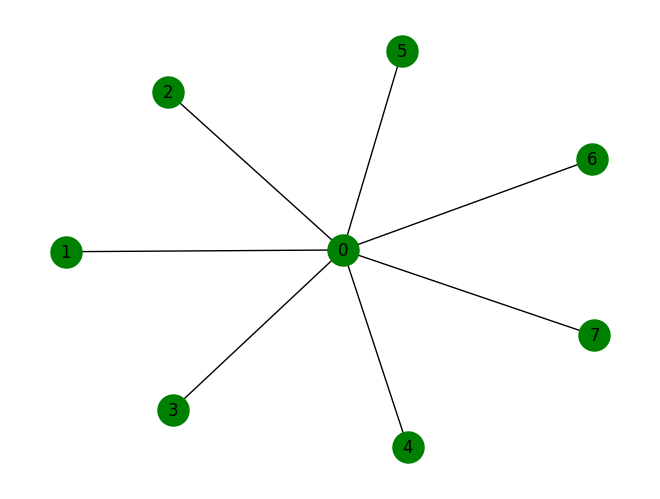

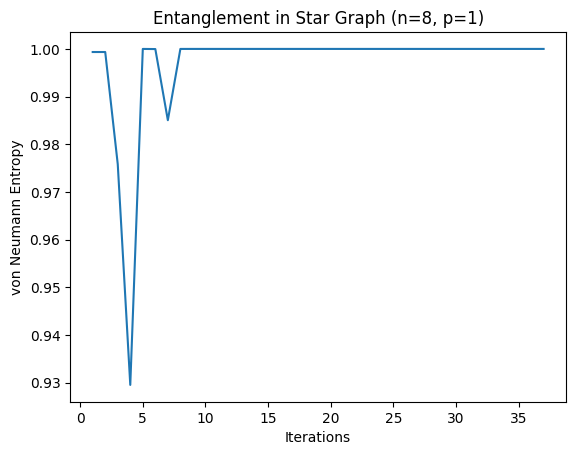

The expectation value of the cut is : 5.3515625.
The solutions are : 00000001, 11111110 with a MaxCut = 7.
--End of 1 layer analysis--
For a Star Graph with 8 nodes/qubits and a QAOA circuit with 2 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 1.580886047054361.
It ranged from 0.9775745480689018 to 1.7206334047508391,with a mean of 1.5369973800508074and a standard deviation of 0.12924093611607784.
The initial parameters were : [1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.14403301 1.57943188 0.77498427 0.82493263].
The total number of iterations required : 48.


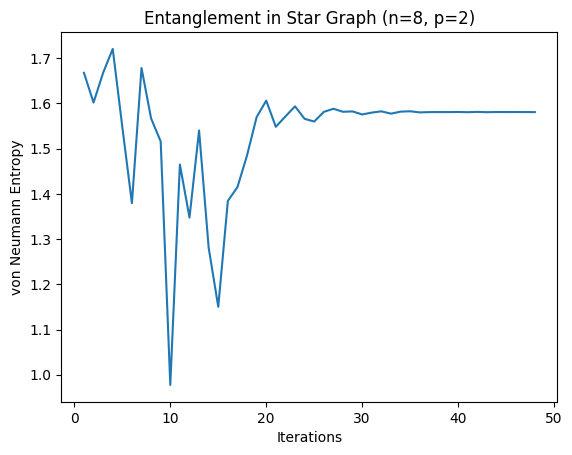

The expectation value of the cut is : 5.3251953125.
The solutions are : 00000001, 11111110 with a MaxCut = 7.
--End of 2 layer analysis--
For a Star Graph with 8 nodes/qubits and a QAOA circuit with 3 layers:
The Schmidt number is : 5.
The final von Neumann entropy is : 1.5753200297212078.
It ranged from 1.3708282461988006 to 2.0330190481996575,with a mean of 1.6600463359998345and a standard deviation of 0.12673660018030647.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.04011394 2.01380262 1.32869438 1.34586239 0.90076771 0.8825639 ].
The total number of iterations required : 88.


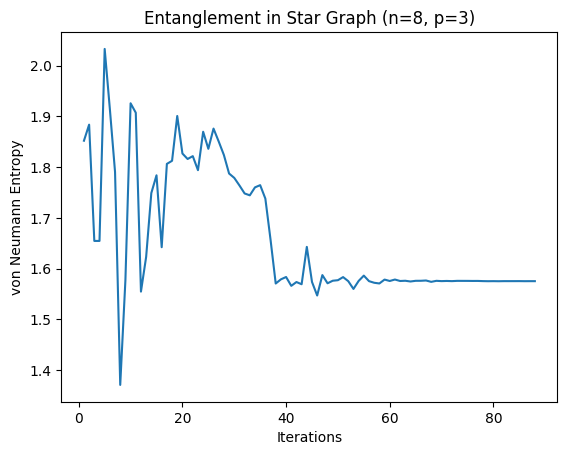

The expectation value of the cut is : 6.2216796875.
The solutions are : 00000001, 11111110 with a MaxCut = 7.
--End of 3 layer analysis--
For a Star Graph with 8 nodes/qubits and a QAOA circuit with 4 layers:
The Schmidt number is : 5.
The final von Neumann entropy is : 1.6820362133143247.
It ranged from 1.5900854830503222 to 2.1642549574672425,with a mean of 1.7435562891024927and a standard deviation of 0.10109630684069827.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.98575938 2.06282443 1.03675571 0.96053317 1.24759513 0.91160563
 0.97837771 1.00807282].
The total number of iterations required : 96.


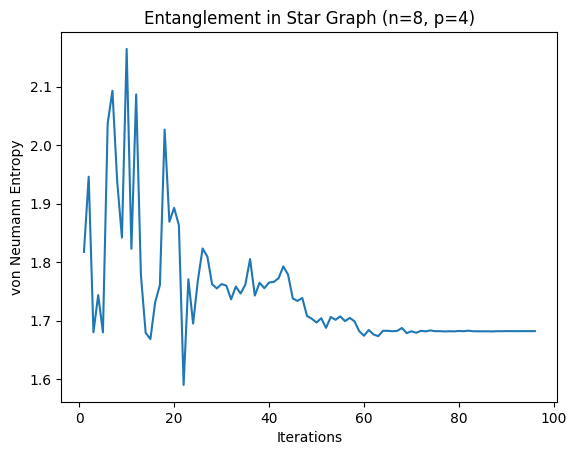

The expectation value of the cut is : 6.294921875.
The solutions are : 00000001, 11111110 with a MaxCut = 7.
--End of 4 layer analysis--
For a Star Graph with 8 nodes/qubits and a QAOA circuit with 5 layers:
The Schmidt number is : 5.
The final von Neumann entropy is : 1.3708652293612151.
It ranged from 1.2452099755511994 to 2.1194040826770175,with a mean of 1.5130155286831224and a standard deviation of 0.21923192525426846.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.08260349 0.90443538 0.85433174 1.72705404 1.02994666 1.55576119
 0.99025762 1.03547537 1.87165263 1.0844065 ].
The total number of iterations required : 124.


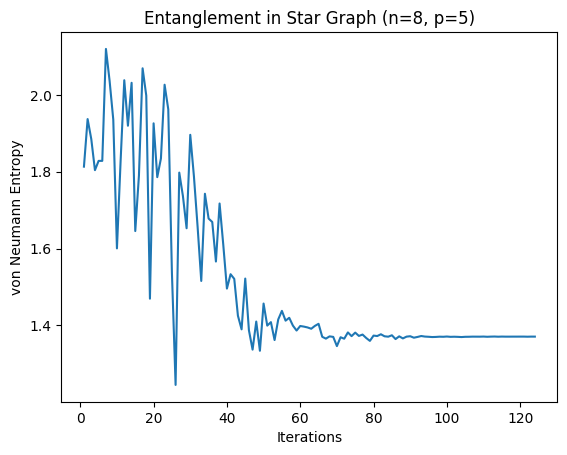

The expectation value of the cut is : 6.6220703125.
The solutions are : 00000001, 11111110 with a MaxCut = 7.
--End of 5 layer analysis--
For a Star Graph with 8 nodes/qubits and a QAOA circuit with 6 layers:
The Schmidt number is : 5.
The final von Neumann entropy is : 1.8905163600946144.
It ranged from 1.351889991418498 to 2.1334421560397425,with a mean of 1.8895563693250679and a standard deviation of 0.09854879006815331.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [2.02589842 1.00368442 1.99501648 1.00037204 1.97827897 1.14853319
 0.99586768 1.01123599 1.00539616 0.98336898 0.99322934 1.92388207].
The total number of iterations required : 133.


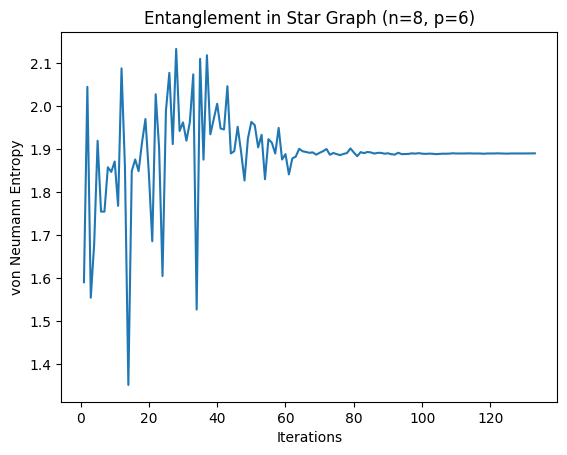

The expectation value of the cut is : 5.22265625.
The solutions are : 00000001, 11111110 with a MaxCut = 7.
--End of 6 layer analysis--
For a Star Graph with 8 nodes/qubits and a QAOA circuit with 7 layers:
The Schmidt number is : 5.
The final von Neumann entropy is : 1.7173527360382848.
It ranged from 1.5978748143911052 to 2.1512872985375657,with a mean of 1.792221861265651and a standard deviation of 0.1140392158937391.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [0.93510915 1.06329252 1.00820982 1.02396725 0.89302248 1.01173831
 1.0392249  1.06546889 1.0091362  0.944785   0.90533678 1.03269595
 1.02809658 0.941749  ].
The total number of iterations required : 182.


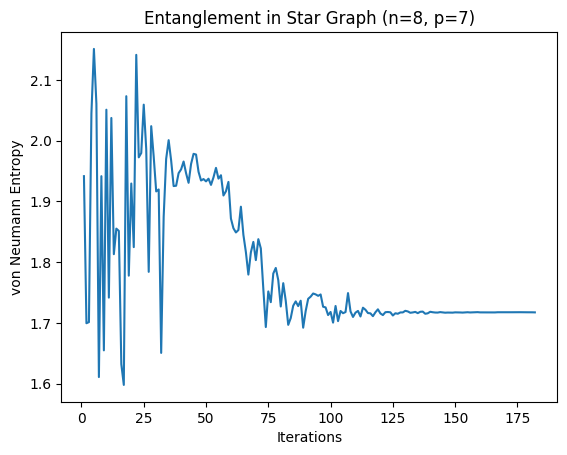

The expectation value of the cut is : 6.271484375.
The solutions are : 00000001, 11111110 with a MaxCut = 7.
--End of 7 layer analysis--
For a Star Graph with 8 nodes/qubits and a QAOA circuit with 8 layers:
The Schmidt number is : 5.
The final von Neumann entropy is : 1.4597528852634667.
It ranged from 1.4343091228177847 to 2.2497945038354956,with a mean of 1.667981167976202and a standard deviation of 0.252877280104737.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [0.79481856 1.16039472 2.13865019 0.60644628 1.02291452 0.81810007
 1.97661846 0.89135822 0.99349631 0.92611265 0.97710484 1.05063943
 0.96876804 0.97343115 0.9176839  0.88230851].
The total number of iterations required : 180.


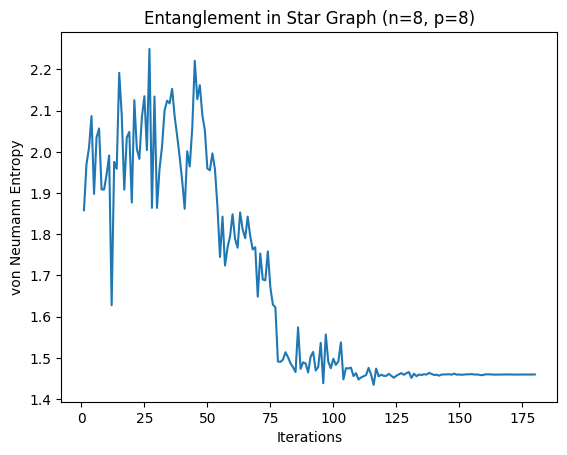

The expectation value of the cut is : 6.513671875.
The solutions are : 00000001, 11111110 with a MaxCut = 7.
--End of 8 layer analysis--


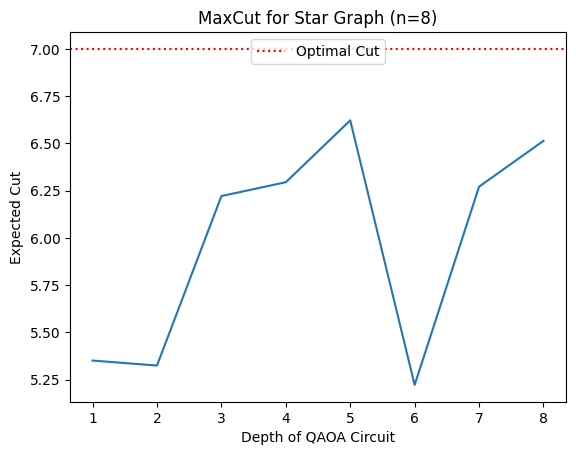

--End of 8 qubit analysis--
--End of Star Graph analysis--
For a Complete Graph with 4 nodes/qubits and a QAOA circuit with 1 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 0.8114858475726201.
It ranged from 0.02238273411790983 to 1.4063271952483625,with a mean of 0.812286872306336and a standard deviation of 0.31631734030789577.
The initial parameters were : [1.0, 1.0].
The optimized parameters are : [ 0.27386881 -0.25638493].
The total number of iterations required : 32.


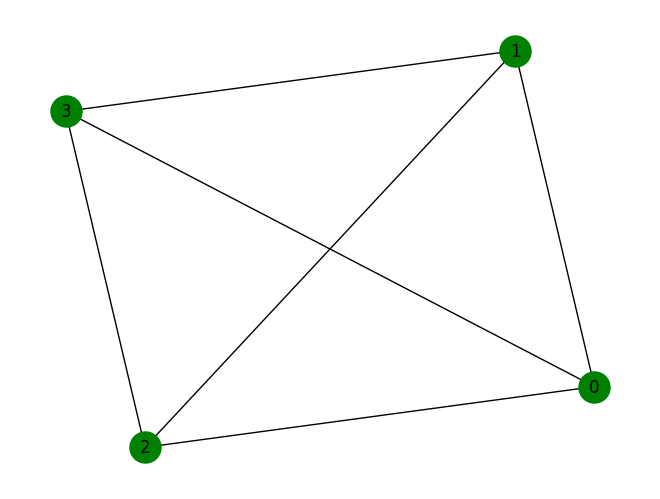

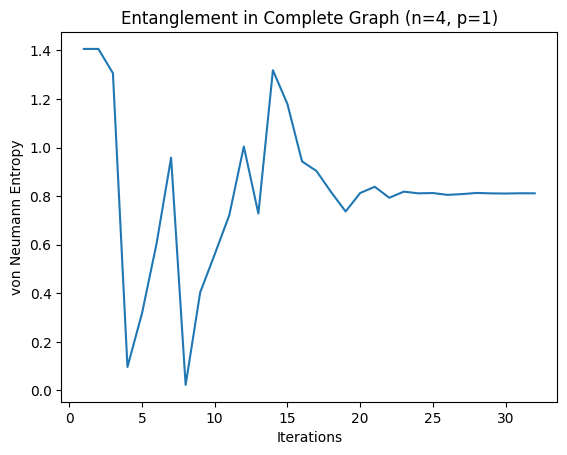

The expectation value of the cut is : 3.6923828125.
The solutions are : 0011, 0101, 0110, 1001, 1010, 1100 with a MaxCut = 4.
--End of 1 layer analysis--
For a Complete Graph with 4 nodes/qubits and a QAOA circuit with 2 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.2410884586647335.
It ranged from 0.648337935049995 to 1.5018040762516167,with a mean of 1.1777525209326016and a standard deviation of 0.1541726274397403.
The initial parameters were : [1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [2.09149094 0.79891856 1.11266271 0.89310857].
The total number of iterations required : 50.


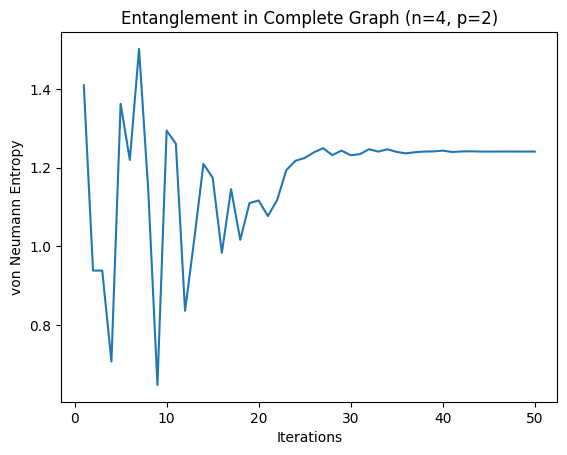

The expectation value of the cut is : 3.9794921875.
The solutions are : 0011, 0101, 0110, 1001, 1010, 1100 with a MaxCut = 4.
--End of 2 layer analysis--
For a Complete Graph with 4 nodes/qubits and a QAOA circuit with 3 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.2462554977907199.
It ranged from 0.03886301344349606 to 1.5376416775578632,with a mean of 1.173037147412776and a standard deviation of 0.26274546450023467.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [0.71587711 0.11419415 0.94376428 1.07077538 0.80323479 0.8382843 ].
The total number of iterations required : 61.


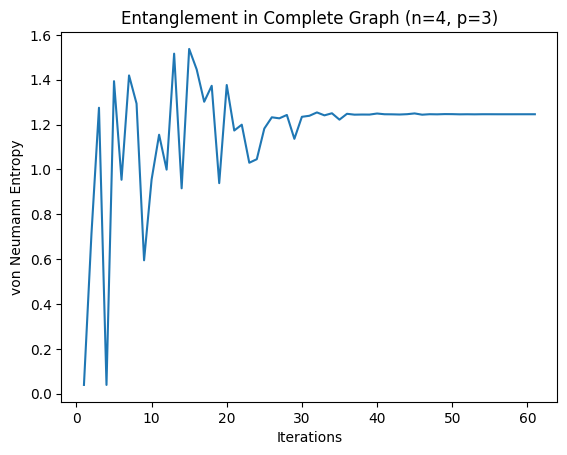

The expectation value of the cut is : 3.9970703125.
The solutions are : 0011, 0101, 0110, 1001, 1010, 1100 with a MaxCut = 4.
--End of 3 layer analysis--
For a Complete Graph with 4 nodes/qubits and a QAOA circuit with 4 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.206618192242327.
It ranged from 0.496210998050624 to 1.5433840120229092,with a mean of 1.2019055556549747and a standard deviation of 0.13478383604160932.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [0.75972825 2.111515   0.85796159 1.0435874  0.64876702 2.26520367
 0.46344658 0.33879382].
The total number of iterations required : 87.


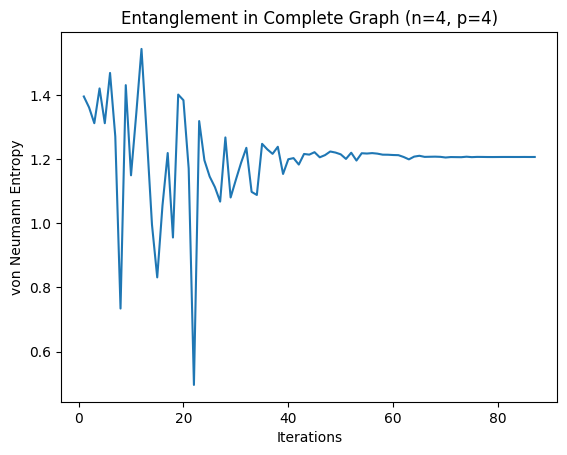

The expectation value of the cut is : 3.984375.
The solutions are : 0011, 0101, 0110, 1001, 1010, 1100 with a MaxCut = 4.
--End of 4 layer analysis--
For a Complete Graph with 4 nodes/qubits and a QAOA circuit with 5 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.250669579487547.
It ranged from 0.5470154878313174 to 1.5174684918036865,with a mean of 1.1748478971427028and a standard deviation of 0.17107290945795034.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [2.02144853 0.89897828 1.11646513 0.97758262 1.01384944 1.09114274
 0.83603749 1.96322956 0.90206152 1.00734027].
The total number of iterations required : 102.


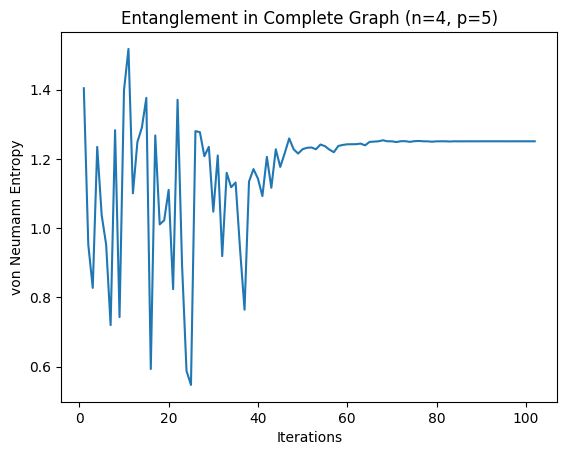

The expectation value of the cut is : 3.9990234375.
The solutions are : 0011, 0101, 0110, 1001, 1010, 1100 with a MaxCut = 4.
--End of 5 layer analysis--
For a Complete Graph with 4 nodes/qubits and a QAOA circuit with 6 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.250292276213979.
It ranged from 0.04934907629151564 to 1.481657568983402,with a mean of 1.1468184641928598and a standard deviation of 0.2733027344698386.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.0289544  1.03007224 0.98157442 1.03814677 1.09606704 0.71174688
 1.1978705  1.03420807 0.9771755  1.09133268 0.92729498 0.9233545 ].
The total number of iterations required : 132.


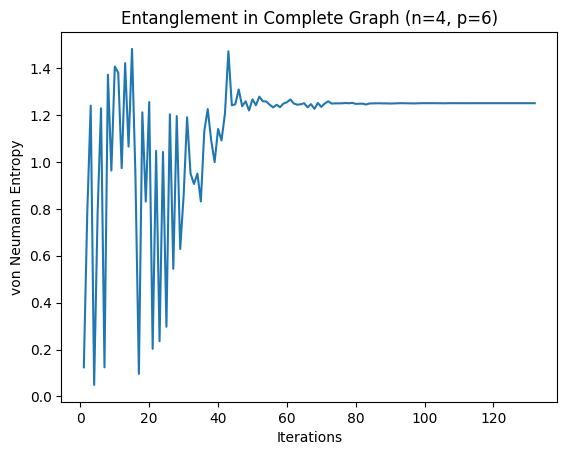

The expectation value of the cut is : 3.9814453125.
The solutions are : 0011, 0101, 0110, 1001, 1010, 1100 with a MaxCut = 4.
--End of 6 layer analysis--
For a Complete Graph with 4 nodes/qubits and a QAOA circuit with 7 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.251669364912483.
It ranged from 0.3945843297217113 to 1.5832224781568762,with a mean of 1.1951435036773375and a standard deviation of 0.17522780594533227.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [0.94779499 2.08783178 0.99892567 0.84420703 0.92563111 1.16290932
 2.30313276 1.08312494 1.00160264 0.88670185 1.01091273 0.9527856
 1.95789341 1.95842028].
The total number of iterations required : 127.


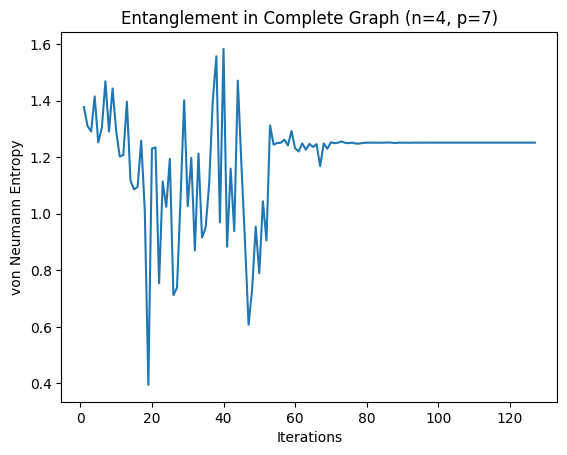

The expectation value of the cut is : 4.0.
The solutions are : 0011, 0101, 0110, 1001, 1010, 1100 with a MaxCut = 4.
--End of 7 layer analysis--
For a Complete Graph with 4 nodes/qubits and a QAOA circuit with 8 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.2511771667768488.
It ranged from 0.5967486509623638 to 1.5567038647714941,with a mean of 1.2032746866307507and a standard deviation of 0.1291506996066402.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.88697336 1.00993252 1.31460581 1.14472777 0.80970761 0.94071308
 0.91425457 0.92025624 0.95889828 1.02175675 1.91158378 0.98774881
 0.97519891 1.07293637 1.04254776 0.97899366].
The total number of iterations required : 169.


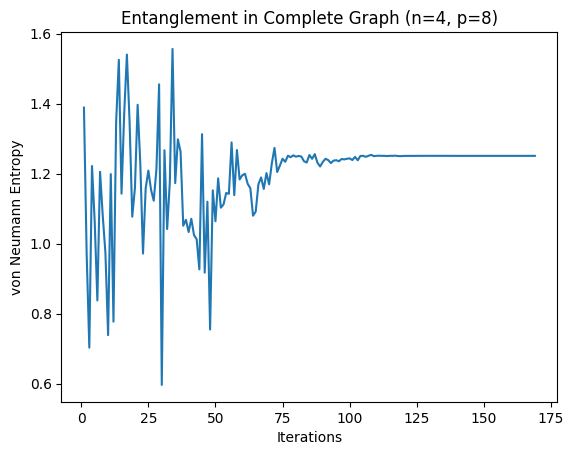

The expectation value of the cut is : 4.0.
The solutions are : 0011, 0101, 0110, 1001, 1010, 1100 with a MaxCut = 4.
--End of 8 layer analysis--


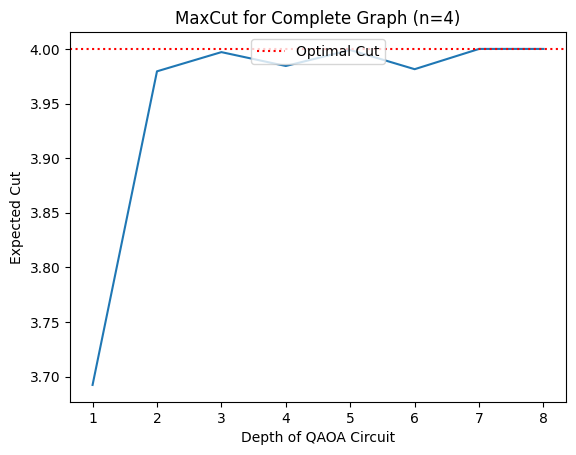

--End of 4 qubit analysis--
For a Complete Graph with 6 nodes/qubits and a QAOA circuit with 1 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 0.880631649407744.
It ranged from 0.014326664229098531 to 1.6476286017062791,with a mean of 1.0663813821391819and a standard deviation of 0.3690203940659728.
The initial parameters were : [1.0, 1.0].
The optimized parameters are : [1.28810279 1.3874883 ].
The total number of iterations required : 33.


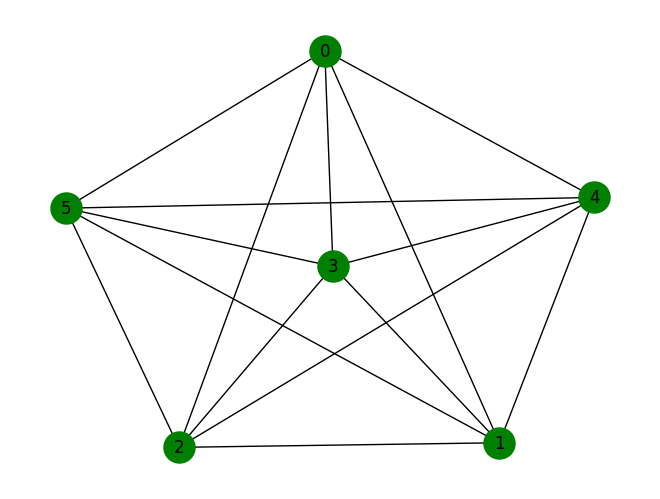

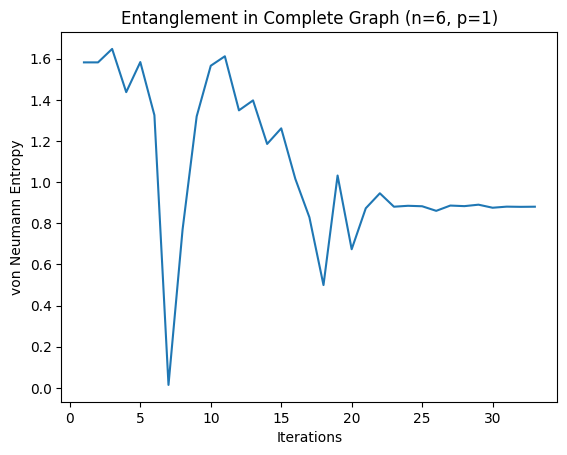

The expectation value of the cut is : 8.595703125.
Traceback (most recent call last):
  Cell In[7], line 108
    opt_cut = -maxcut_obj(maxcounts[0][::-1], G)
IndexError: list index out of range

Use %tb to get the full traceback.


In [7]:
# Optimizing
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

n_list = [4, 6, 8]
g_list = [0, 1, 2]
graph_name = ['Complete Bipartite Graph', 'Star Graph', 'Complete Graph'] 
p_list = [i for i in range(1, 1 + max(n_list))]

schmidt = 0
vN_Gnp = []
iter_Gnp = []
exp_cut_Gnp = []
opt_cut_Gn = []
    
for i in range(0, len(g_list)):
    vN_np = []
    iter_np = []
    exp_cut_np = []
    opt_cut_n = []
    
    g = g_list[i]
    g_name = graph_name[i]
    
    for j in range(0, len(n_list)):
        vN_p = []
        iter_p = []
        exp_cut_p = []
        
        n = n_list[j]
        G = graph_maker(n,g)

        expectation = get_expectation(G)

        for k in range(0,len(p_list)):
            vN = []
            iter_num = 0
            
            p = p_list[k]
            theta_seed = [1.0 for i in range(0,2*p)]

            res = minimize(expectation, theta_seed, method='COBYLA')

            iter_list = [(1+i) for i in range(0,iter_num)] #list of iterations for particular G,n,p

            #print(res)
            
            print(f'For a {g_name} with {n} nodes/qubits and a QAOA circuit with {p} layers:')
            print(f'The Schmidt number is : {schmidt}.')

            vN_stat = pd.Series(vN)
            vN_final = vN[-1]
            vN_min = vN_stat.describe().loc['min']
            vN_max = vN_stat.describe().loc['max']
            vN_mean = vN_stat.describe().loc['mean']
            vN_std = vN_stat.describe().loc['std']
            
            vN_prop = [vN_final, vN_min, vN_max, vN_mean, vN_std] #all the properties of vN for particular G,n,p
            
            print(f'The final von Neumann entropy is : {vN_final}.')
            print(f'It ranged from {vN_min} to {vN_max},'
                  f'with a mean of {vN_mean}'
                  f'and a standard deviation of {vN_std}.')
            
            print(f'The initial parameters were : {theta_seed}.')
            print(f'The optimized parameters are : {res.x}.')
            #print(f'The final objective function is : {res.fun}')
            print(f'The total number of iterations required : {res.nfev}.')

            #print(vN)
            #print(iter_list)
            plt.figure()
            plt.plot(iter_list, vN)
            plt.title(f'Entanglement in {g_name} (n={n}, p={p})')
            plt.xlabel('Iterations')
            plt.ylabel('von Neumann Entropy')
            # Show/save figure as desired.
            plt.show()

            #fig, axs = plt.subplots()
            #fig.suptitle(f'{g_name} (n={n}, p=1)')
            #axs.plot(iter_list, vN)
            #axs.set_xlabel('Iterations')
            #axs.set_ylabel('von Neumann Entropy')


            backend = Aer.get_backend('aer_simulator')
            backend.shots = 2048

            qc_res = create_qaoa_circ(G, res.x)

            counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
            
            exp_cut = -compute_expectation(counts, G)
            
            %matplotlib inline
            
            plot_histogram(counts, title=f'MaxCut Solutions for {g_name} (n={n}, p={p})').show()
            
            print(f'The expectation value of the cut is : {exp_cut}.')

            
            filtered_counts = dict(filter(lambda item: item[1] > 100, counts.items()))
            maxcounts = list(filtered_counts.keys())
            sortedmax = sorted(maxcounts, key=lambda x: int(x, 2))
            
            opt_cut = -maxcut_obj(maxcounts[0][::-1], G)
            
            

            print(f'The solutions are : {", ".join(sortedmax)} with a MaxCut = {opt_cut}.')
            print(f'--End of {p} layer analysis--')
            
            vN_p.append(vN_prop) #all the properties of vN for particular G,n
            iter_p.append(iter_list) #list of iterations for all p 
            exp_cut_p.append(exp_cut)
        
        plt.figure()
        plt.plot(p_list, exp_cut_p)
        plt.title(f'MaxCut for {g_name} (n={n})')
        plt.xlabel('Depth of QAOA Circuit')
        plt.ylabel('Expected Cut')
        plt.axhline(y=opt_cut,linestyle=':',color='r', label='Optimal Cut')
        leg = plt.legend(loc='upper center')
        # Show/save figure as desired.
        plt.show()
        
        vN_np.append(vN_p) #all the properties of vN for particular G
        iter_np.append(iter_p) #list of iterations for all n,p
        exp_cut_np.append(exp_cut_p)
        opt_cut_n.append(opt_cut)
        
        print(f'--End of {n} qubit analysis--')
        
    vN_Gnp.append(vN_np)
    iter_Gnp.append(iter_np)
    exp_cut_Gnp.append(exp_cut_np)
    opt_cut_Gn.append(opt_cut_n)
    
    print(f'--End of {g_name} analysis--')